This notebook provides example on how to run the main analysis routines. Example data that can be used here is available in the heiDATA repository XXX. Be aware that this procedure is deconvoluting and tracking through large 3D+time datasets, and requires significant computational ressources!

In [1]:
import ImageAnalysisCode as iac
import os

/home/bq_llettermann/.conda/envs/JAX22GPU/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
DATA_REPO = '/bwSDS/sd23l003/llettermann/ChiralityPaperData/DataRepository/' # Should point to data repo from https://doi.org/10.11588/DATA/4YBYXE

In [3]:
file_path = os.path.join(DATA_REPO, '3D_Microscopy_Data', 'Example_Microscopy_Session.mvd2')
out_path = os.path.join(DATA_REPO, '3D_Microscopy_Data', 'Outputs') # Change to not overwrite included files
out_path_precomp = os.path.join(DATA_REPO, '3D_Microscopy_Data', 'Outputs_Precomputed') # Change to not overwrite included files
series = 1 # Series to analyze, in the example session series 0,1,2,6,7,8 are full 3D time series

In [ ]:
# deconvolute the data
import jax # Import JAX to check whether GPUs are used if available
# If no GPU with large memory is available, the following line forces JAX to use CPU, uncomment to use GPU (CPU deconvolution is much slower)
jax.config.update('jax_platform_name', 'cpu')
print('Using JAX backend:', jax.lib.xla_bridge.get_backend().platform)
iac.pipelines.deconvolute(file_path, 
                          series, 
                          out_path+'/', 
                          epochs=10,   # usually 1000 epochs are ok, this however can take hours depending on the available GPU
                          batchsize=1, # Increase to speed up, depends on available memory (of GPU if using one) 
                          shift=False  # Correct for shift in the data, this is not needed for the example data
                          )

Using JAX backend: cpu


SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.


Dropping indices  (array([], dtype=int64),)  for empty
Pixelsvalues above 928.1 taken, of which in dataset are 920525, meaning fraction of 5.0e-04.
smallest_number of samples availabel:  21701
Sporointensity self choosen: 2756.0
Epoch 000, Loss: 6.587e+07, Normalization Image: 4776267.00000, Normalization PSF: 1.00008
Epoch 009, Loss: 5.188e+07, Normalization Image: 4840656.50000, Normalization PSF: 1.00406


In [6]:
# Threshold and track the data
iac.pipelines.tresh_and_track(out_path+'/', # Uses the deconvoluted data, writes the results to the same folder
                              dilate=0, # Dilation of threshholded tracks, helps for sparse signals, problematic at high density
                              name='PC', # Tag to give to results
                              dname='PC', # Tag for the deconvoluted data
                              max_reconn_dist = 10 # Maximum distance for re-connection of tracks
                              )

Forward complete 0
Backward complete 0
Forward complete 1
Backward complete 1
Forward complete 2
Backward complete 2
17 Labels Added
493 265


In [7]:
# Reduce the sporozoite size of threshholded data and find the biocenter of the sporozoites
iac.pipelines.skin_sporos(out_path+'/', 
                          name='PC', # Tag to give to results
                          dname='PC' # Tag for the deconvoluted data
                          )

In [8]:
# Fit the resulting trajectories with helical segments to get the chirality and quantify helix parameters
iac.pipelines.fit_trajectories(out_path+'/', 
                               epochs=10000,
                               name='PC',
                               dname='PC')

/home/bq_llettermann/PhD/Paper/Chirality/GitCode/hei-sporo-code-tracking/ImageAnalysisCode/plot.py:12: RuntimeWarning: All-NaN slice encountered
  max_norms = np.nanmax(norms, axis=1)
/home/bq_llettermann/PhD/Paper/Chirality/GitCode/hei-sporo-code-tracking/ImageAnalysisCode/plot.py:13: RuntimeWarning: All-NaN slice encountered
  ptp = np.linalg.norm(np.nanmax(com_skinned, axis=1)-np.nanmin(com_skinned, axis=1), axis=1)


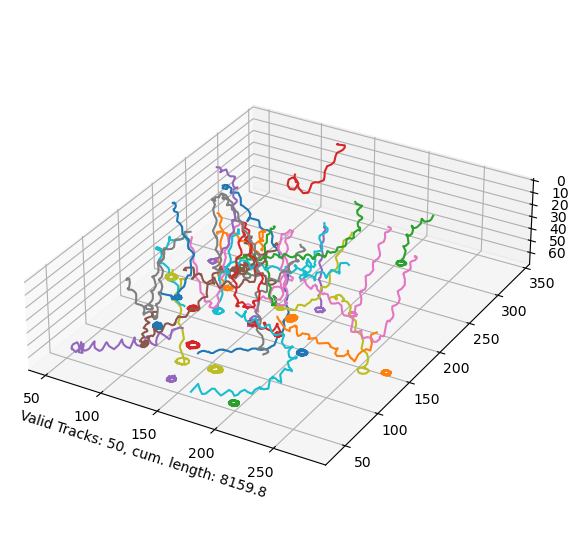

In [4]:
# Visualize tracks:
track_path = os.path.join(out_path_precomp, 'PC_Biocents_units.npy')
iac.plot.plot_tracks(track_path);

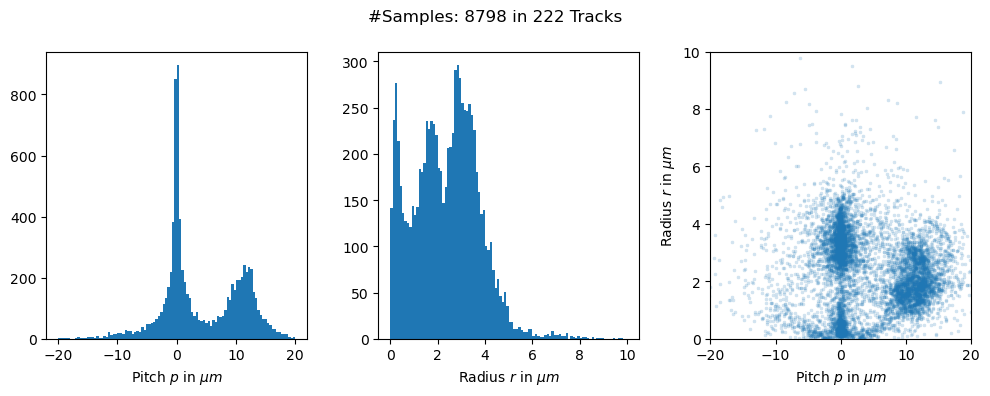

In [7]:
# Visualize helix parameters (this includes now 2D at bottom and 3D in bulk trajectories):
helix_path = os.path.join(out_path_precomp, 'PC_Helixfits.npy')
iac.plot.plot_helixprops(helix_path, show=True)